In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import motornet as mn

file_dir = sys.path[0]
sys.path.append(os.path.dirname(file_dir[:file_dir.rfind('tutorials')]))

%load_ext autoreload
%autoreload 2
print('\n')
print('tensorflow version: ' + tf.__version__)
print('numpy version: ' + np.__version__)




tensorflow version: 2.7.0
numpy version: 1.21.5


<Figure size 432x288 with 0 Axes>

# 0. Object hierarchy
### <span style="color:gray">I. Build a plant</span>
### <span style="color:gray">II. Build and run a network</span>
### <span style="color:gray">III. Build a task</span>



<img src="img/serial.png" alt="drawing" width="500"/>

#

<img src="img/hierarchy.png" alt="drawing" width="500"/>




### <span style="color:gray">0. Object hierarchy</span>
# I. Build a plant
## 1. Relu point mass
### <span style="color:gray">II. Build and run a network</span>
### <span style="color:gray">III. Build a task</span>



![](img/pointmass.png)

#

![](img/pointmass-coord.png)


In [2]:

skeleton = mn.plants.skeletons.PointMass(space_dim=2, mass=5.)
muscle = mn.plants.muscles.ReluMuscle()
point_mass = mn.plants.Plant(skeleton=skeleton, muscle_type=muscle, excitation_noise_sd=10**-4)

# PointMass skeletons only have one "bone", which is the point itself.
point_mass.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[2, 2], [0, 0]], name='UpRight', max_isometric_force=500)
point_mass.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[-2, 2], [0, 0]], name='UpLeft', max_isometric_force=500)
point_mass.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[2, -2], [0, 0]], name='DownRight', max_isometric_force=500)
point_mass.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[-2, -2], [0, 0]], name='DownLeft', max_isometric_force=500)



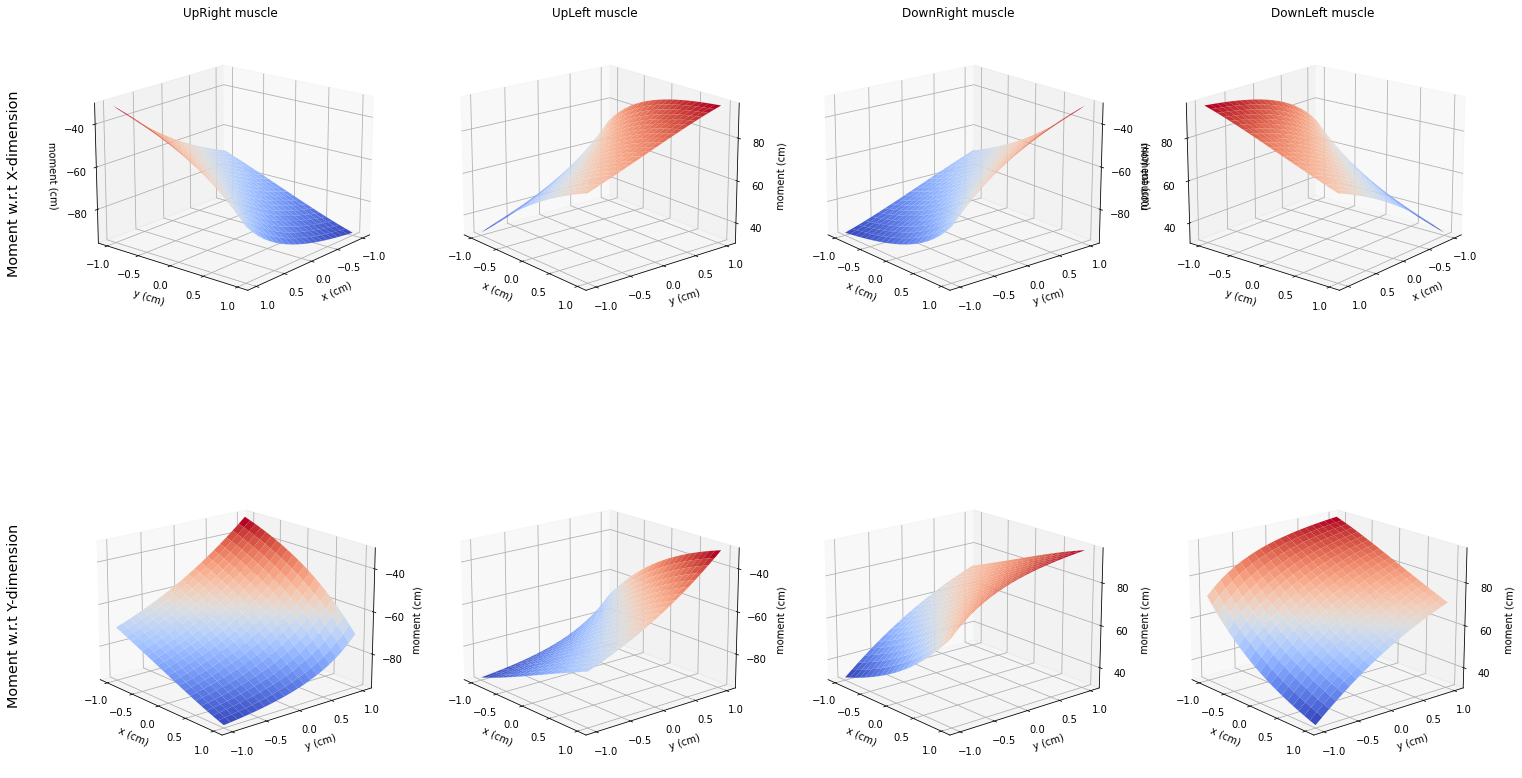

In [3]:

# create initial conditions
n_states = 21  # grid resolution
x, y = np.meshgrid(
    np.linspace(point_mass.pos_lower_bound[0], point_mass.pos_upper_bound[0], n_states).astype('float32'),
    np.linspace(point_mass.pos_lower_bound[1], point_mass.pos_upper_bound[1], n_states).astype('float32'))


# pass the initial joint space to get the full initial states
# The initial state should be a 4-items list containing:
#             [joint_state, cartesian_state, muscle_state, geometry_state]

state0 = point_mass.get_initial_state(joint_state=tf.stack([x.reshape(-1), y.reshape(-1)], axis=1))
mstate = state0[-2].numpy().reshape((n_states, n_states, -1, point_mass.n_muscles))
gstate = state0[-1].numpy().reshape((n_states, n_states, -1, point_mass.n_muscles))


fig = plt.figure()
fig.set_size_inches((25, 15))
# fig.patch.set_facecolor('xkcd:white')

for muscle in range(point_mass.n_muscles):
    for k in range(point_mass.dof):
        subplot = k * point_mass.n_muscles + muscle + 1
        ax = fig.add_subplot(point_mass.dof, point_mass.n_muscles, subplot, projection='3d')

        z = gstate[:, :, 2+k, muscle] * 100  # m to cm
        ax.plot_surface(x, y, z, cmap=plt.get_cmap('coolwarm'))

        ax.set_xlabel('x (cm)')
        ax.set_ylabel('y (cm)')
        ax.set_zlabel('moment (cm)')
        if k == 0:
            ax.set_title(point_mass.muscle_name[muscle] + " muscle")

        # adjust angle of view
        if (muscle==0 or muscle==3) and k == 0:
            ax.view_init(18, 40)
        else:
          ax.view_init(18, -40)
        ax.locator_params(nbins=6)

fig.text(0.085, 0.7, 'Moment w.r.t X-dimension', va='center', rotation='vertical', fontsize='x-large')
fig.text(0.085, 0.3, 'Moment w.r.t Y-dimension', va='center', rotation='vertical', fontsize='x-large')
plt.show()


### <span style="color:gray">0. Object hierarchy</span>
# I. Build a plant
## 2. arm210
### <span style="color:gray">II. Build and run a network</span>
### <span style="color:gray">III. Build a task</span>



<img src="img/arm210.png" alt="drawing" width="500"/>


In [4]:


arm210 = mn.plants.Plant(
  skeleton=mn.plants.skeletons.TwoDofArm(),
  muscle_type=mn.plants.muscles.RigidTendonHillMuscleThelen())

arm210.add_muscle(
  path_fixation_body=[0., 1.],
  path_coordinates=[[-.15, .03], [.094, 0.017]],
  name='pectoralis',
  max_isometric_force=838,
  tendon_length=.039,
  optimal_muscle_length=.134,
  normalized_slack_muscle_length=1.48)

arm210.add_muscle(
  path_fixation_body=[0., 1.],
  path_coordinates=[[-.034, .022], [.144, 0.01]],
  name='clavicular deltoid',
  max_isometric_force=680,
  tendon_length=.039,
  optimal_muscle_length=.104,
  normalized_slack_muscle_length=1.4)

arm210.add_muscle(
  path_fixation_body=[0., 0., 1.],
  path_coordinates=[[.14, 0.], [.05, -.00], [0.153, 0.]],
  name='deltoid',
  max_isometric_force=1207,
  tendon_length=.066,
  optimal_muscle_length=.140,
  normalized_slack_muscle_length=1.52)

arm210.add_muscle(
  path_fixation_body=[0., 0., 1.],
  path_coordinates=[[.1, 0.], [.05, -.03], [0.062, 0.004]],
  name='teres major',
  max_isometric_force=1207,
  tendon_length=.066,
  optimal_muscle_length=.068,
  normalized_slack_muscle_length=1.65)

arm210.add_muscle(
  path_fixation_body=[1., 2.],
  path_coordinates=[[0.23, 0.001], [0.231, 0.01]],
  name='brachioradialis',
  max_isometric_force=1422,
  tendon_length=.172,
  optimal_muscle_length=.092,
  normalized_slack_muscle_length=1.43)

arm210.add_muscle(
  path_fixation_body=[1., 1., 2.],
  path_coordinates=[[0.03, 0.], [0.138, -0.019], [-0.04, -0.017]],
  name='tricepslat',
  max_isometric_force=1549,
  tendon_length=.187,
  optimal_muscle_length=.093,
  normalized_slack_muscle_length=1.45)

arm210.add_muscle(
  path_fixation_body=[0., 2.],
  path_coordinates=[[-0.052, 0.033], [0.044, 0.001]],
  name='biceps',
  max_isometric_force=414,
  tendon_length=.204,
  optimal_muscle_length=.137,
  normalized_slack_muscle_length=1.5)

arm210.add_muscle(
  path_fixation_body=[0., 2.],
  path_coordinates=[[0.02, -0.028], [-0.04, -0.017]],
  name='tricepslong',
  max_isometric_force=603,
  tendon_length=0.217,
  optimal_muscle_length=0.127,
  normalized_slack_muscle_length=1.4)

arm210.add_muscle(
  path_fixation_body=[1., 2.],
  path_coordinates=[[0.306, -0.011], [0.003, -0.025]],
  name='anconeus',
  max_isometric_force=300,
  tendon_length=0.01,
  optimal_muscle_length=0.015,
  normalized_slack_muscle_length=1.72)

arm210.add_muscle(
  path_fixation_body=[1., 2.],
  path_coordinates=[[0.277, 0.], [0.075, 0.02]],
  name='prot',
  max_isometric_force=700,
  tendon_length=0.02,
  optimal_muscle_length=0.058,
  normalized_slack_muscle_length=1.48)

print('Plant built.')


Plant built.


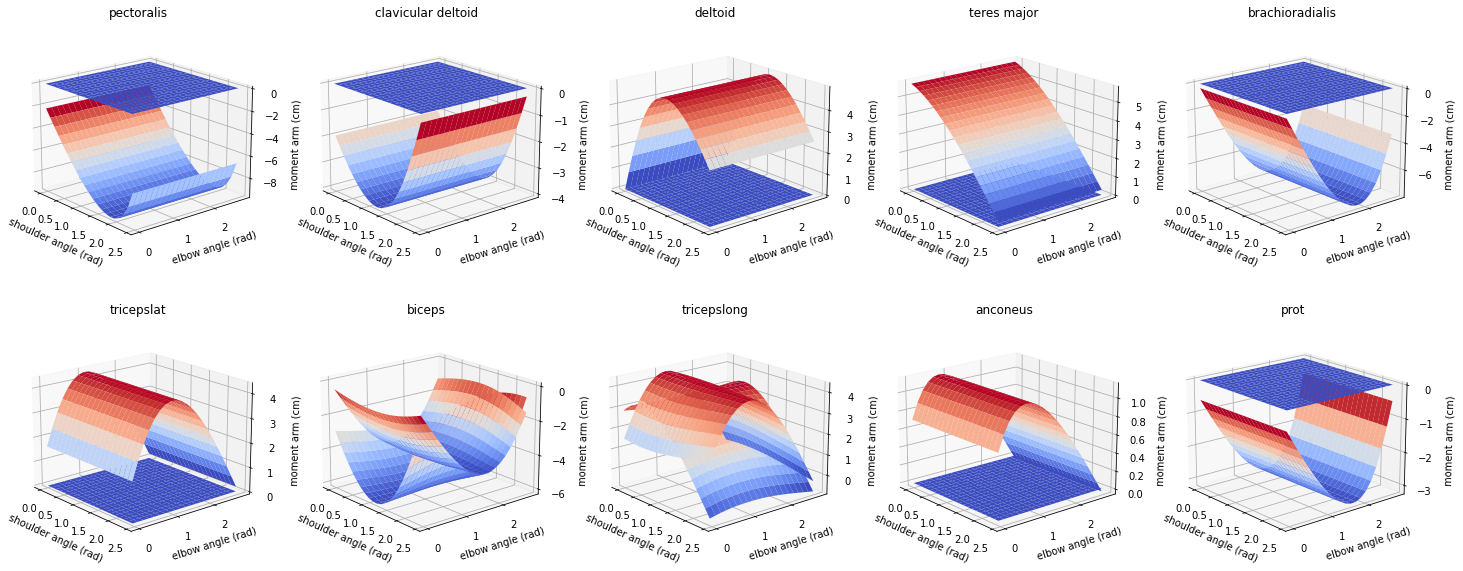

In [5]:

# create a grid of joint angles
n_states = 21  # grid resolution
sho, elb = np.meshgrid(
    np.linspace(arm210.pos_lower_bound[0], arm210.pos_upper_bound[0], n_states).astype('float32'),
    np.linspace(arm210.pos_lower_bound[1], arm210.pos_upper_bound[1], n_states).astype('float32'))

state0 = arm210.get_initial_state(joint_state=tf.stack([sho.reshape(-1), elb.reshape(-1)], axis=1))
mstate = state0[-2].numpy().reshape((n_states, n_states, -1, arm210.n_muscles))
gstate = state0[-1].numpy().reshape((n_states, n_states, -1, arm210.n_muscles))


fig = plt.figure(figsize=(25, 10))
fig.patch.set_facecolor('xkcd:white')
# fig.set_tight_layout(True)
for m in range(arm210.n_muscles):
    ax = fig.add_subplot(2, 5, m+1, projection='3d')
    ax.plot_surface(sho, elb, gstate[:, :, 2, m] * 100, cmap=plt.get_cmap('coolwarm'))
    ax.plot_surface(sho, elb, gstate[:, :, 3, m] * 100, cmap=plt.get_cmap('coolwarm'))
    ax.set_xlabel('shoulder angle (rad)')
    ax.set_ylabel('elbow angle (rad)')
    ax.set_zlabel('moment arm (cm)')
    ax.view_init(18, -40)
    ax.locator_params(nbins=6)
    plt.title(arm210.muscle_name[m])
plt.show()


### <span style="color:gray">0. Object hierarchy</span>
# I. Build a plant
## 3. Numerical Integration
### <span style="color:gray">II. Build and run a network</span>
### <span style="color:gray">III. Build a task</span>


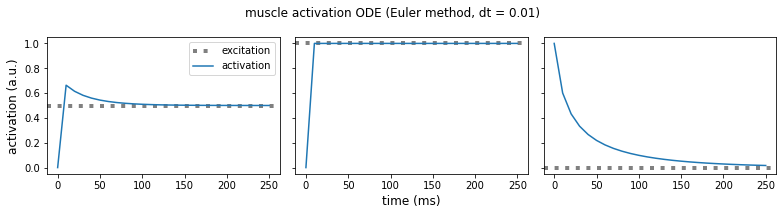

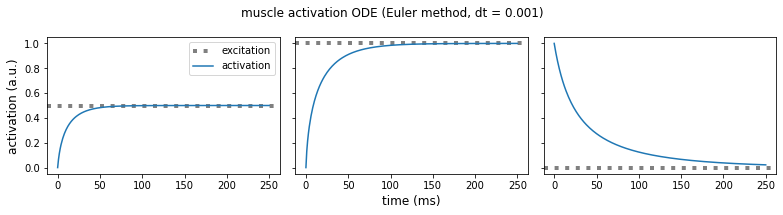

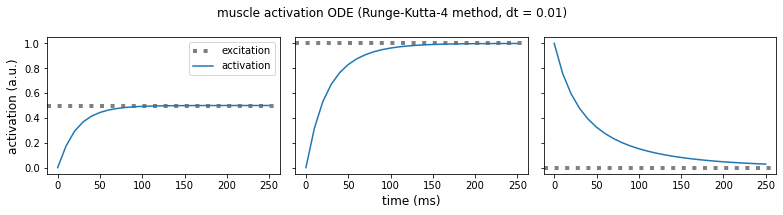

In [6]:
def integrate_activation(plant, excitation_pattern, movement_duration, initial_value):
    t_fn = np.arange(0., movement_duration, plant.dt)

    js, _, ms, gs = plant.get_initial_state(joint_state=tf.zeros((1, 4)))
    ms = tf.concat([tf.ones((1, 1, plant.n_muscles)) * initial_value, ms[:, 1:, :]], axis=1)

    m_states = ms
    inputs = tf.ones((1, plant.n_muscles)) * excitation_pattern

    for _ in range(len(t_fn)):
        js, _, ms, gs = plant(inputs, js, ms, gs)
        m_states = tf.concat([m_states, ms], axis=0)

    return m_states


def plot_integration(plant, title):
  fig, axs = plt.subplots(1, 3, sharey='all', sharex='all')
  fig.set_tight_layout(True)
  fig.set_size_inches((11, 3))

  mvt_dur = 0.25
  xticks = np.linspace(0, mvt_dur, int(mvt_dur / plant.dt)+1) * 1000  # sec to ms

  ms = integrate_activation(plant, [0.5,0,0,0,0,0], mvt_dur, 0)
  axs[0].axhline(0.5, c='grey', ls=':', lw=4, label='excitation')
  axs[0].plot(xticks, ms[:, 0, 0], label='activation')
  axs[0].set_ylabel('activation (a.u.)', fontsize=12)
  axs[0].legend()

  ms = integrate_activation(plant, [1,0,0,0,0,0], mvt_dur, 0)
  axs[1].axhline(1, c='grey', ls=':', lw=4, label='excitation')
  axs[1].plot(xticks, ms[:, 0, 0], label='activation')
  axs[1].set_xlabel('time (ms)', fontsize=12)

  ms = integrate_activation(plant, [0,0,0,0,0,0], mvt_dur, 1)
  axs[2].axhline(0, c='grey', ls=':', lw=4, label='excitation')
  axs[2].plot(xticks, ms[:, 0, 0], label='activation')

  fig.suptitle(title)



muscle_type = mn.plants.muscles.RigidTendonHillMuscleThelen()

arm26 = mn.plants.RigidTendonArm26(muscle_type=muscle_type)
plot_integration(arm26, 'muscle activation ODE (Euler method, dt = 0.01)')

arm26 = mn.plants.RigidTendonArm26(muscle_type=muscle_type, timestep=0.001)
plot_integration(arm26, 'muscle activation ODE (Euler method, dt = 0.001)')

arm26 = mn.plants.RigidTendonArm26(muscle_type=muscle_type, integration_method='rk4')
plot_integration(arm26, 'muscle activation ODE (Runge-Kutta-4 method, dt = 0.01)')



### <span style="color:gray">0. Object hierarchy</span>
### <span style="color:gray">I. Build a plant</span>
# II. Build and run a network
## 1. Working example
### <span style="color:gray">III. Build a task</span>


In [7]:

plant = mn.plants.ReluPointMass24()
network = mn.nets.layers.GRUNetwork(plant=plant, n_units=50, kernel_regularizer=10**-6, name='network')
task = mn.tasks.CentreOutReach(network=network)

rnn = tf.keras.layers.RNN(cell=network, return_sequences=True, name='RNN')

inputs = task.get_input_dict_layers()
state0 = task.get_initial_state_layers()
states_out = rnn(inputs, initial_state=state0)

model = mn.nets.MotorNetModel(inputs=[inputs, state0], outputs=states_out, name='model', task=task)
model.compile(optimizer=tf.optimizers.Adam(clipnorm=1.), loss=task.losses, loss_weights=task.loss_weights)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 5)]    0           []                               
                                                                                                  
 joint0 (InputLayer)            [(None, 4)]          0           []                               
                                                                                                  
 cartesian0 (InputLayer)        [(None, 4)]          0           []                               
                                                                                                  
 muscle0 (InputLayer)           [(None, 4, 4)]       0           []                               
                                                                                              

What is a tensor?

### <span style="color:gray">0. Object hierarchy</span>
### <span style="color:gray">I. Build a plant</span>
# II. Build and run a network
## 2. Input types
### <span style="color:gray">III. Build a task</span>


In [8]:

for k, v in inputs.items():
    print(k + " :--> ", v)


inputs :-->  KerasTensor(type_spec=TensorSpec(shape=(None, None, 5), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")


In [9]:

for s in state0:
    print(s)


KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='joint0'), name='joint0', description="created by layer 'joint0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='cartesian0'), name='cartesian0', description="created by layer 'cartesian0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4), dtype=tf.float32, name='muscle0'), name='muscle0', description="created by layer 'muscle0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4), dtype=tf.float32, name='geometry0'), name='geometry0', description="created by layer 'geometry0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 1), dtype=tf.float32, name='proprio_feedback0'), name='proprio_feedback0', description="created by layer 'proprio_feedback0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2, 1), dtype=tf.float32, name='visual_feedback0'), name='visual_feedback0', description="created by layer 'visual_feedback0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.fl

In [10]:

for k, v in states_out.items():
    print(k + " :--> ", v)


joint position :-->  KerasTensor(type_spec=TensorSpec(shape=(None, None, 4), dtype=tf.float32, name=None), name='RNN/transpose_5:0', description="created by layer 'RNN'")
cartesian position :-->  KerasTensor(type_spec=TensorSpec(shape=(None, None, 4), dtype=tf.float32, name=None), name='RNN/transpose_1:0', description="created by layer 'RNN'")
muscle state :-->  KerasTensor(type_spec=TensorSpec(shape=(None, None, 4, 4), dtype=tf.float32, name=None), name='RNN/transpose_6:0', description="created by layer 'RNN'")
geometry state :-->  KerasTensor(type_spec=TensorSpec(shape=(None, None, 4, 4), dtype=tf.float32, name=None), name='RNN/transpose_3:0', description="created by layer 'RNN'")
proprioceptive feedback :-->  KerasTensor(type_spec=TensorSpec(shape=(None, None, 8, 1), dtype=tf.float32, name=None), name='RNN/transpose_7:0', description="created by layer 'RNN'")
visual feedback :-->  KerasTensor(type_spec=TensorSpec(shape=(None, None, 2, 1), dtype=tf.float32, name=None), name='RNN/tran

What is a tensor?

### <span style="color:gray">0. Object hierarchy</span>
### <span style="color:gray">I. Build a plant</span>
# II. Build and run a network
## 3. Losses & loss weights
### <span style="color:gray">III. Build a task</span>


In [11]:
task.losses

{'joint position': None,
 'cartesian position': <motornet.nets.losses.PositionLoss at 0x15f42154190>,
 'muscle state': <motornet.nets.losses.L2xDxActivationLoss at 0x15f42154160>,
 'geometry state': None,
 'proprioceptive feedback': None,
 'visual feedback': None,
 'excitation': None,
 'gru_hidden0': <motornet.nets.losses.L2xDxRegularizer at 0x15f42154130>}

In [12]:
task.loss_weights

{'joint position': 0.0,
 'cartesian position': 1.0,
 'muscle state': 5,
 'geometry state': 0.0,
 'proprioceptive feedback': 0.0,
 'visual feedback': 0.0,
 'excitation': 0.0,
 'gru_hidden0': 0.1}

In [13]:

loss = mn.nets.losses.L2Regularizer()
task.add_loss(assigned_output='muscle state', loss=loss, loss_weight=4., name='muscle ' + loss.name)

task.losses


{'joint position': None,
 'cartesian position': <motornet.nets.losses.PositionLoss at 0x15f42154190>,
 'muscle state': <motornet.nets.losses.L2Regularizer at 0x15f4208d850>,
 'geometry state': None,
 'proprioceptive feedback': None,
 'visual feedback': None,
 'excitation': None,
 'gru_hidden0': <motornet.nets.losses.L2xDxRegularizer at 0x15f42154130>}

In [14]:

task.loss_weights

{'joint position': 0.0,
 'cartesian position': 1.0,
 'muscle state': 4.0,
 'geometry state': 0.0,
 'proprioceptive feedback': 0.0,
 'visual feedback': 0.0,
 'excitation': 0.0,
 'gru_hidden0': 0.1}

### <span style="color:gray">0. Object hierarchy</span>
### <span style="color:gray">I. Build a plant</span>
# II. Build and run a network
## 4. Training
### <span style="color:gray">III. Build a task</span>

In [15]:

n_t = 100
n_batches = 4
batch_size = 32

[inputs, targets, init_states] = task.generate(n_timesteps=n_t, batch_size=n_batches * batch_size)
model.fit(x=[inputs, init_states], y=targets, verbose=1, epochs=1, batch_size=batch_size, shuffle=False)

4/4 [==============================] - 6s 139ms/step - loss: 20.3979 - position_loss: 0.3533 - gru_regularizer_loss: 0.4433 - l2_xdx_activation_loss: 5.0001



### <span style="color:gray">0. Object hierarchy</span>
### <span style="color:gray">I. Build a plant</span>
### <span style="color:gray">II. Build and run a network</span>
# III. Build a task</span>
## 1. "generate" method and output


In [16]:

class RandomTargetReach(mn.tasks.Task):
    def __init__(self, network, **kwargs):
        super().__init__(network, **kwargs)
        self.__name__ = 'RandomTargetReach'
        max_iso_force = self.network.plant.muscle.max_iso_force
        deriv_weight = kwargs.get('deriv_weight', 0.)
        dt = self.network.plant.dt
        muscle_loss = mn.nets.losses.L2xDxActivationLoss(max_iso_force=max_iso_force, dt=dt, deriv_weight=deriv_weight)
        gru_loss = mn.nets.losses.L2xDxRegularizer(deriv_weight=0.05, dt=self.network.plant.dt)
        self.add_loss('gru_hidden0', loss_weight=0.1, loss=gru_loss)
        self.add_loss('muscle state', loss_weight=5, loss=muscle_loss)
        self.add_loss('cartesian position', loss_weight=1., loss=mn.nets.losses.PositionLoss())

    def generate(self, batch_size, n_timesteps):
        init_states = self.get_initial_state(batch_size=batch_size)
        goal_states_j = self.network.plant.draw_random_uniform_states(batch_size=batch_size)
        goal_states = self.network.plant.joint2cartesian(goal_states_j)
        targets = self.network.plant.state2target(state=goal_states, n_timesteps=n_timesteps).numpy()
        inputs = {"inputs": targets[:, :, :self.network.plant.space_dim]}
        return [inputs, targets, init_states]



example_task = RandomTargetReach(network=network)

[i, t, s0] = example_task.generate(batch_size=10, n_timesteps=100)





### <span style="color:gray">0. Object hierarchy</span>
### <span style="color:gray">I. Build a plant</span>
### <span style="color:gray">II. Build and run a network</span>
# III. Build a task</span>
## 2. Loss functions


In [17]:

from tensorflow.python.keras.losses import LossFunctionWrapper
from tensorflow.python.keras.utils import losses_utils


def _l2_activation_loss(y_true, y_pred, extra_arg):
    activation = tf.slice(y_pred, [0, 0, 0, 0], [-1, -1, 1, -1])
    return extra_arg * tf.reduce_mean(activation ** 2)


class L2ActivationLoss(LossFunctionWrapper):

    def __init__(self, extra_arg: int, name: str = 'l2_activation', reduction=losses_utils.ReductionV2.AUTO):
        super().__init__(_l2_activation_loss, name=name, reduction=reduction, extra_arg=extra_arg)
        self.extra_arg = extra_arg


loss = L2ActivationLoss(extra_arg=1, name='example_loss')

